In [119]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator
import tmap as tm


from mobius import ForceField, VirtualTarget

## Load dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
                (~mhci['affinity_binding'].isin(dirty_values))]

In [114]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        product = torch.mm(x1, x2.transpose(1, 0))
        denominator = torch.add(x2s, x1s[:, None]) - product
        sim_mt = product / denominator
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %04d/%d - Loss: %.3f   noise: %.3f   kernel scale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item(),
            model.covar_module.raw_outputscale
        ))
        
        optimizer.step()

In [115]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [116]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

## Random train-test (70/30) split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(mhci['sequence'], mhci['energy'], test_size=0.3)

print(X_train.shape, X_test.shape)

X_train_fps = map4_fingerprint(X_train)
X_test_fps = map4_fingerprint(X_test)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

(5956,) (2553,)


In [117]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_fps, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_fps, y_train, training_iter=1000)

Iter 0001/1000 - Loss: 1.890   noise: 0.693   kernel scale: 0.000
Iter 0002/1000 - Loss: 1.855   noise: 0.744   kernel scale: 0.100
Iter 0003/1000 - Loss: 1.828   noise: 0.798   kernel scale: 0.199
Iter 0004/1000 - Loss: 1.802   noise: 0.852   kernel scale: 0.298
Iter 0005/1000 - Loss: 1.783   noise: 0.908   kernel scale: 0.395
Iter 0006/1000 - Loss: 1.767   noise: 0.963   kernel scale: 0.491
Iter 0007/1000 - Loss: 1.754   noise: 1.018   kernel scale: 0.584
Iter 0008/1000 - Loss: 1.746   noise: 1.072   kernel scale: 0.676
Iter 0009/1000 - Loss: 1.738   noise: 1.123   kernel scale: 0.765
Iter 0010/1000 - Loss: 1.731   noise: 1.171   kernel scale: 0.851
Iter 0011/1000 - Loss: 1.728   noise: 1.216   kernel scale: 0.935
Iter 0012/1000 - Loss: 1.727   noise: 1.257   kernel scale: 1.015
Iter 0013/1000 - Loss: 1.724   noise: 1.294   kernel scale: 1.093
Iter 0014/1000 - Loss: 1.721   noise: 1.325   kernel scale: 1.167
Iter 0015/1000 - Loss: 1.722   noise: 1.352   kernel scale: 1.239
Iter 0016/

Iter 0126/1000 - Loss: 1.682   noise: 0.762   kernel scale: 3.628
Iter 0127/1000 - Loss: 1.682   noise: 0.760   kernel scale: 3.634
Iter 0128/1000 - Loss: 1.685   noise: 0.758   kernel scale: 3.640
Iter 0129/1000 - Loss: 1.683   noise: 0.757   kernel scale: 3.646
Iter 0130/1000 - Loss: 1.682   noise: 0.755   kernel scale: 3.652
Iter 0131/1000 - Loss: 1.680   noise: 0.754   kernel scale: 3.657
Iter 0132/1000 - Loss: 1.686   noise: 0.752   kernel scale: 3.663
Iter 0133/1000 - Loss: 1.683   noise: 0.750   kernel scale: 3.668
Iter 0134/1000 - Loss: 1.683   noise: 0.749   kernel scale: 3.673
Iter 0135/1000 - Loss: 1.681   noise: 0.748   kernel scale: 3.678
Iter 0136/1000 - Loss: 1.682   noise: 0.746   kernel scale: 3.683
Iter 0137/1000 - Loss: 1.684   noise: 0.746   kernel scale: 3.689
Iter 0138/1000 - Loss: 1.677   noise: 0.745   kernel scale: 3.694
Iter 0139/1000 - Loss: 1.679   noise: 0.744   kernel scale: 3.700
Iter 0140/1000 - Loss: 1.683   noise: 0.744   kernel scale: 3.705
Iter 0141/

Iter 0251/1000 - Loss: 1.682   noise: 0.710   kernel scale: 3.955
Iter 0252/1000 - Loss: 1.682   noise: 0.709   kernel scale: 3.955
Iter 0253/1000 - Loss: 1.683   noise: 0.709   kernel scale: 3.955
Iter 0254/1000 - Loss: 1.684   noise: 0.708   kernel scale: 3.955
Iter 0255/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.955
Iter 0256/1000 - Loss: 1.684   noise: 0.707   kernel scale: 3.955
Iter 0257/1000 - Loss: 1.684   noise: 0.707   kernel scale: 3.956
Iter 0258/1000 - Loss: 1.684   noise: 0.708   kernel scale: 3.956
Iter 0259/1000 - Loss: 1.686   noise: 0.708   kernel scale: 3.957
Iter 0260/1000 - Loss: 1.685   noise: 0.709   kernel scale: 3.958
Iter 0261/1000 - Loss: 1.680   noise: 0.710   kernel scale: 3.958
Iter 0262/1000 - Loss: 1.686   noise: 0.711   kernel scale: 3.958
Iter 0263/1000 - Loss: 1.682   noise: 0.712   kernel scale: 3.959
Iter 0264/1000 - Loss: 1.685   noise: 0.713   kernel scale: 3.959
Iter 0265/1000 - Loss: 1.682   noise: 0.713   kernel scale: 3.959
Iter 0266/

Iter 0376/1000 - Loss: 1.682   noise: 0.712   kernel scale: 3.971
Iter 0377/1000 - Loss: 1.684   noise: 0.712   kernel scale: 3.970
Iter 0378/1000 - Loss: 1.681   noise: 0.710   kernel scale: 3.970
Iter 0379/1000 - Loss: 1.682   noise: 0.709   kernel scale: 3.969
Iter 0380/1000 - Loss: 1.687   noise: 0.708   kernel scale: 3.968
Iter 0381/1000 - Loss: 1.685   noise: 0.708   kernel scale: 3.968
Iter 0382/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.968
Iter 0383/1000 - Loss: 1.684   noise: 0.707   kernel scale: 3.967
Iter 0384/1000 - Loss: 1.680   noise: 0.707   kernel scale: 3.967
Iter 0385/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.967
Iter 0386/1000 - Loss: 1.678   noise: 0.707   kernel scale: 3.966
Iter 0387/1000 - Loss: 1.685   noise: 0.707   kernel scale: 3.966
Iter 0388/1000 - Loss: 1.684   noise: 0.706   kernel scale: 3.966
Iter 0389/1000 - Loss: 1.681   noise: 0.706   kernel scale: 3.965
Iter 0390/1000 - Loss: 1.684   noise: 0.707   kernel scale: 3.966
Iter 0391/

Iter 0501/1000 - Loss: 1.678   noise: 0.707   kernel scale: 3.978
Iter 0502/1000 - Loss: 1.682   noise: 0.707   kernel scale: 3.977
Iter 0503/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.978
Iter 0504/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.978
Iter 0505/1000 - Loss: 1.680   noise: 0.708   kernel scale: 3.978
Iter 0506/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.978
Iter 0507/1000 - Loss: 1.680   noise: 0.707   kernel scale: 3.978
Iter 0508/1000 - Loss: 1.681   noise: 0.708   kernel scale: 3.979
Iter 0509/1000 - Loss: 1.684   noise: 0.708   kernel scale: 3.979
Iter 0510/1000 - Loss: 1.682   noise: 0.708   kernel scale: 3.979
Iter 0511/1000 - Loss: 1.686   noise: 0.707   kernel scale: 3.979
Iter 0512/1000 - Loss: 1.685   noise: 0.709   kernel scale: 3.979
Iter 0513/1000 - Loss: 1.683   noise: 0.711   kernel scale: 3.980
Iter 0514/1000 - Loss: 1.683   noise: 0.712   kernel scale: 3.981
Iter 0515/1000 - Loss: 1.681   noise: 0.713   kernel scale: 3.980
Iter 0516/

Iter 0626/1000 - Loss: 1.682   noise: 0.714   kernel scale: 3.971
Iter 0627/1000 - Loss: 1.685   noise: 0.713   kernel scale: 3.970
Iter 0628/1000 - Loss: 1.686   noise: 0.712   kernel scale: 3.970
Iter 0629/1000 - Loss: 1.683   noise: 0.712   kernel scale: 3.969
Iter 0630/1000 - Loss: 1.682   noise: 0.711   kernel scale: 3.968
Iter 0631/1000 - Loss: 1.683   noise: 0.710   kernel scale: 3.967
Iter 0632/1000 - Loss: 1.681   noise: 0.708   kernel scale: 3.966
Iter 0633/1000 - Loss: 1.679   noise: 0.707   kernel scale: 3.965
Iter 0634/1000 - Loss: 1.683   noise: 0.706   kernel scale: 3.965
Iter 0635/1000 - Loss: 1.684   noise: 0.706   kernel scale: 3.965
Iter 0636/1000 - Loss: 1.684   noise: 0.706   kernel scale: 3.965
Iter 0637/1000 - Loss: 1.683   noise: 0.706   kernel scale: 3.965
Iter 0638/1000 - Loss: 1.682   noise: 0.707   kernel scale: 3.966
Iter 0639/1000 - Loss: 1.685   noise: 0.708   kernel scale: 3.967
Iter 0640/1000 - Loss: 1.685   noise: 0.710   kernel scale: 3.969
Iter 0641/

Iter 0751/1000 - Loss: 1.682   noise: 0.724   kernel scale: 3.982
Iter 0752/1000 - Loss: 1.682   noise: 0.724   kernel scale: 3.982
Iter 0753/1000 - Loss: 1.683   noise: 0.723   kernel scale: 3.982
Iter 0754/1000 - Loss: 1.682   noise: 0.722   kernel scale: 3.981
Iter 0755/1000 - Loss: 1.682   noise: 0.720   kernel scale: 3.980
Iter 0756/1000 - Loss: 1.683   noise: 0.718   kernel scale: 3.979
Iter 0757/1000 - Loss: 1.683   noise: 0.716   kernel scale: 3.978
Iter 0758/1000 - Loss: 1.683   noise: 0.713   kernel scale: 3.976
Iter 0759/1000 - Loss: 1.680   noise: 0.711   kernel scale: 3.974
Iter 0760/1000 - Loss: 1.682   noise: 0.709   kernel scale: 3.973
Iter 0761/1000 - Loss: 1.683   noise: 0.707   kernel scale: 3.973
Iter 0762/1000 - Loss: 1.679   noise: 0.705   kernel scale: 3.972
Iter 0763/1000 - Loss: 1.680   noise: 0.703   kernel scale: 3.971
Iter 0764/1000 - Loss: 1.680   noise: 0.702   kernel scale: 3.971
Iter 0765/1000 - Loss: 1.684   noise: 0.701   kernel scale: 3.971
Iter 0766/

Iter 0876/1000 - Loss: 1.681   noise: 0.704   kernel scale: 3.979
Iter 0877/1000 - Loss: 1.683   noise: 0.703   kernel scale: 3.978
Iter 0878/1000 - Loss: 1.684   noise: 0.701   kernel scale: 3.978
Iter 0879/1000 - Loss: 1.681   noise: 0.700   kernel scale: 3.977
Iter 0880/1000 - Loss: 1.680   noise: 0.700   kernel scale: 3.977
Iter 0881/1000 - Loss: 1.680   noise: 0.700   kernel scale: 3.978
Iter 0882/1000 - Loss: 1.685   noise: 0.702   kernel scale: 3.979
Iter 0883/1000 - Loss: 1.681   noise: 0.703   kernel scale: 3.981
Iter 0884/1000 - Loss: 1.681   noise: 0.706   kernel scale: 3.983
Iter 0885/1000 - Loss: 1.682   noise: 0.708   kernel scale: 3.986
Iter 0886/1000 - Loss: 1.685   noise: 0.710   kernel scale: 3.988
Iter 0887/1000 - Loss: 1.684   noise: 0.712   kernel scale: 3.989
Iter 0888/1000 - Loss: 1.683   noise: 0.713   kernel scale: 3.990
Iter 0889/1000 - Loss: 1.682   noise: 0.713   kernel scale: 3.989
Iter 0890/1000 - Loss: 1.681   noise: 0.712   kernel scale: 3.989
Iter 0891/

R2   : 0.588
RMSD : 1.211 kcal/mol


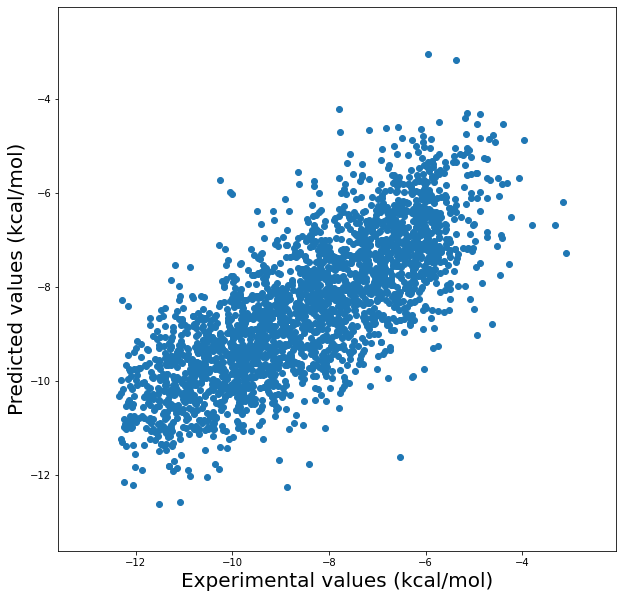

In [118]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename='correlation_exp_pred_MAP4_fps_tanimoto_mhc-i_cleaned_all_size_pep.png')

## Bayesian opt. prototype

In [40]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        print(x1.shape)
        print(x2.shape)
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        print(x1.shape)
        print(x2.shape)
        product = torch.mm(x1, x2.transpose(1, 0))
        denominator = torch.add(x2s, x1s[:, None]) - product
        sim_mt = product / denominator
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())
        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [41]:
def get_fitted_model(train_x, train_y, state_dict=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [20]:
# fit the model
model = get_fitted_model(X_train_fps, y_train)

R2   : 0.597
RMSD : 1.201 kcal/mol


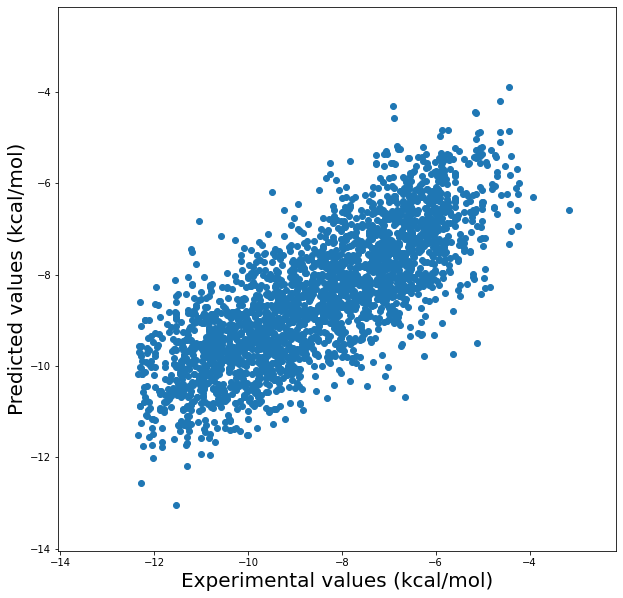

In [27]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_test_fps)
 
print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy(), fig_filename=None)

In [239]:
low_affinity = mhci[mhci['energy'] >= -8.5]
high_affinity = mhci[mhci['energy'] < -8.5]

ids = np.random.randint(low=0, high=low_affinity.shape[0], size=500)

X_train, y_train = low_affinity['sequence'].values[ids], low_affinity['energy'].values[ids]
X_pool, y_pool = high_affinity['sequence'], high_affinity['energy']

print('Train: %4d - %.3f %%' % (X_train.shape[0], X_train.shape[0] / mhci.shape[0]* 100.))
print('Pool : %4d - %.3f %%' % (X_pool.shape[0], X_pool.shape[0] / mhci.shape[0]* 100.))

Train:  500 - 5.876 %
Pool : 4148 - 48.748 %


In [240]:
X_train_fps = map4_fingerprint(X_train)
X_pool_fps = map4_fingerprint(X_pool)

y_train = torch.from_numpy(y_train).float()
y_pool = torch.from_numpy(y_pool.values).float()

In [229]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        product = torch.mm(x1, x2.transpose(1, 0))
        denominator = torch.add(x2s, x1s[:, None]) - product
        sim_mt = product / denominator
        
        if diag:
            sim_mt = sim_mt[0]
        
        return sim_mt

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())
        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [230]:
def get_fitted_model(train_x, train_y, state_dict=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [231]:
model = get_fitted_model(X_train_fps, y_train)

R2   : 0.034
RMSD : 2.901 kcal/mol


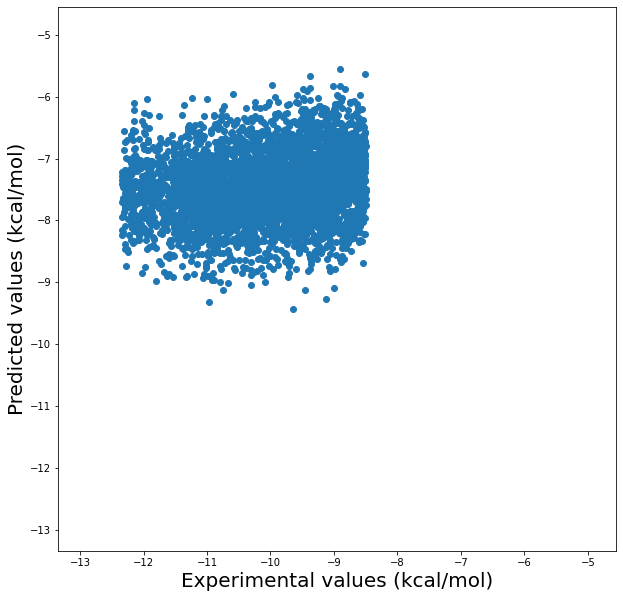

In [232]:
# Predict energy for test set
observed_pred = predict(model, model.likelihood, X_pool_fps)
 
print('R2   : %.3f' % pearsonr(y_pool, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(y_pool, observed_pred.mean.numpy()))

# Plot results
plot(y_pool.numpy(), observed_pred.mean.numpy(), fig_filename=None)

In [298]:
# expected improvement acquisition function
def expected_improvement(model, Y_train, Xsamples):
    # calculate the best surrogate score found so far
    best = np.min(Y_train.numpy())
    
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    # calculate the expected improvement
    imp = mu - best
    Z = imp / sigma
    ei = (imp * norm.cdf(Z)) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] = 0.0
    
    return ei

# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples):
    # calculate the best surrogate score found so far
    best = np.min(Y_train.numpy())
    
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (sigma + 1E-9))
    
    return probs

<AxesSubplot:>

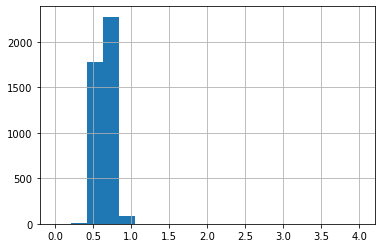

In [299]:
p = expected_improvement(model, y_train, X_pool_fps)
pd.Series(p).hist(bins=np.linspace(0, 4, 20))

<AxesSubplot:>

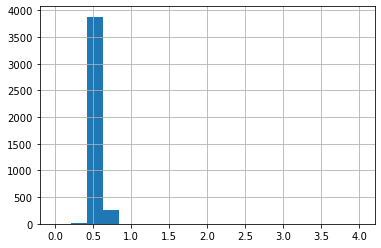

In [300]:
p = probability_of_improvement(model, y_train, X_pool_fps)
pd.Series(p).hist(bins=np.linspace(0, 4, 20))

In [303]:
cX_train_fps = X_train_fps.clone()
cy_train = y_train.clone()
cX_pool_fps = X_pool_fps.clone()
cy_pool = y_pool.clone()

n_pep = 96

print('Init.')
print('Train: ', cX_train_fps.shape[0])
print('Pool : ', cX_pool_fps.shape[0])
print('Best peptide: %.3f' % cy_train.min())
for n in [-12, -11, -10]:
    print('N pep under %d kcal/mol: %03d' % (n, cy_train[cy_train < n].shape[0]))
    
print()

for i in range(5):
    print(i + 1)
    model = get_fitted_model(cX_train_fps, cy_train)
    
    p = expected_improvement(model, cy_train, cX_pool_fps)
    #p = probability_of_improvement(model, cy_train, cX_pool_fps)
    indices = np.argsort(p)[::-1]
    
    # Add new data to train dataset
    cX_train_fps = torch.cat([cX_train_fps, torch.from_numpy(cX_pool_fps.numpy()[indices[:n_pep]]).float()])
    cy_train = torch.cat([cy_train, torch.from_numpy(cy_pool.numpy()[indices[:n_pep]]).float()])
    print('Train: ', cX_train_fps.shape[0])
    
    # Remove peptides from pool
    cX_pool_fps = cX_pool_fps[n_pep:]
    cy_pool = cy_pool[n_pep:]
    print('Pool : ', cX_pool_fps.shape[0])
    print('Best peptide: %.3f' % cy_train.min())
    
    for n in [-12, -11, -10]:
        x = cy_train[cy_train < n].shape[0]
        print('N pep under %d kcal/mol: %03d (%.3f)' % (n, x, x / (n_pep * (i + 1)) * 100.))
    
    print()

Init.
Train:  500
Pool :  4148
Best peptide: -8.491
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000

1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


Train:  596
Pool :  4052
Best peptide: -11.933
N pep under -12 kcal/mol: 000 (0.000)
N pep under -11 kcal/mol: 007 (7.292)
N pep under -10 kcal/mol: 023 (23.958)

2
Train:  692
Pool :  3956
Best peptide: -11.933
N pep under -12 kcal/mol: 000 (0.000)
N pep under -11 kcal/mol: 017 (8.854)
N pep under -10 kcal/mol: 049 (25.521)

3
Train:  788
Pool :  3860
Best peptide: -12.202
N pep under -12 kcal/mol: 001 (0.347)
N pep under -11 kcal/mol: 022 (7.639)
N pep under -10 kcal/mol: 065 (22.569)

4
Train:  884
Pool :  3764
Best peptide: -12.202
N pep under -12 kcal/mol: 001 (0.260)
N pep under -11 kcal/mol: 023 (5.990)
N pep under -10 kcal/mol: 079 (20.573)

5
Train:  980
Pool :  3668
Best peptide: -12.202
N pep under -12 kcal/mol: 001 (0.208)
N pep under -11 kcal/mol: 027 (5.625)
N pep under -10 kcal/mol: 094 (19.583)



In [256]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(4 * 1e-9)

-11.526768696740188

R2   : 0.066
RMSD : 1.178 kcal/mol


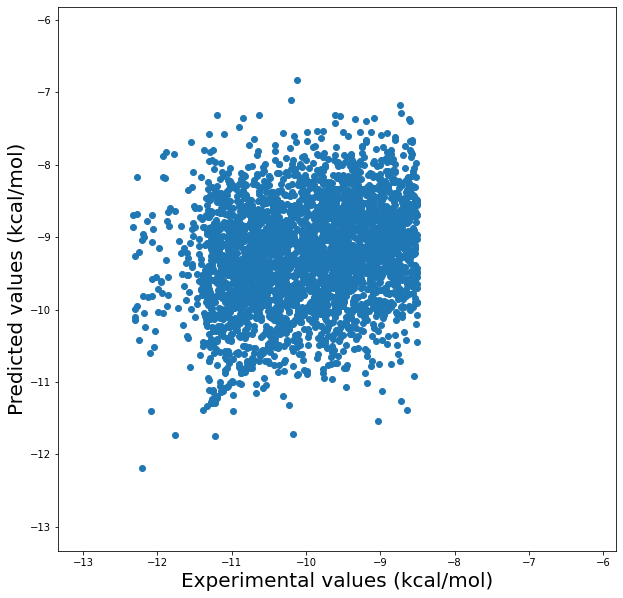

In [304]:
model = get_fitted_model(cX_train_fps, cy_train)

# Predict energy for test set
observed_pred = predict(model, model.likelihood, cX_pool_fps)
 
print('R2   : %.3f' % pearsonr(cy_pool, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(cy_pool, observed_pred.mean.numpy()))

# Plot results
plot(cy_pool.numpy(), observed_pred.mean.numpy(), fig_filename=None)

R2   : 1.000
RMSD : 0.020 kcal/mol


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


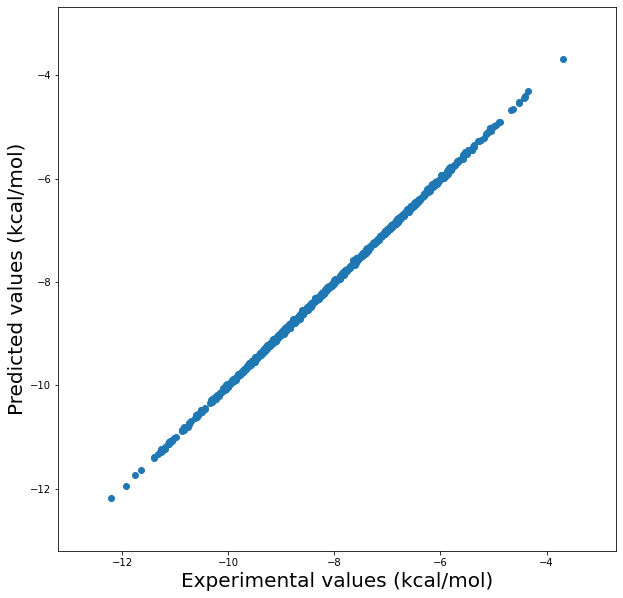

In [305]:
model = get_fitted_model(cX_train_fps, cy_train)

# Predict energy for test set
observed_pred = predict(model, model.likelihood, cX_train_fps)
 
print('R2   : %.3f' % pearsonr(cy_train, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f kcal/mol' % rmsd(cy_train, observed_pred.mean.numpy()))

# Plot results
plot(cy_train.numpy(), observed_pred.mean.numpy(), fig_filename=None)